### Storm fault footprint test ###

Testing creating a GIF of faults/population for a specific storm.

Ben Hutchins, June 13th 2025

In [1]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd
import geopandas as gpd
import shapely
import rasterio

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the shapefile path
DNO_shpfile_path = "/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shx"

In [3]:
DNO_shpfile_path

'/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shx'

In [4]:
shapefile_paths = {
    "DNO": Path("/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp")
}

In [5]:
# Read in NESO's DNO shapefile with geopandas
dno_shapes = gpd.read_file(shapefile_paths["DNO"])

In [6]:
dno_shapes.head()

,geometry
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5..."
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ..."
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926..."
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53...."
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383..."


Load in the fault data for the relevant regions

In [7]:
# Set up the paths
fault_paths = {
    "SSEN_Scotland": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SSEN/nafirs-all-faults-shepd.xlsx"),
    "SSEN_South": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SSEN/nafirs-all-faults-sepd.xlsx"),
    "SPEN": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SPEN/all-lv-faults-spd-spm.csv"),
    "ENWL": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/ENWL/unplanned-outages.csv"),
    "NPG_lv": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/NPG/Northern_Powergrid_LV_Data_2025-04-30-05-00-38_MET Office.xlsb"),
    "NPG_hv": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/NPG/Northern_Powergrid_HV_Data_2025-04-30-05-00-38_MET Office.xlsb"),
}

In [8]:
#-------------------------------
# SSEN North Scotland Faults
#-------------------------------

# Load in the SSEN_Scotland data as xlsx
ssen_scotland_faults = pd.read_excel(fault_paths["SSEN_Scotland"])

# Subset to "Reporting Year" == 2024 (April 2023 to March 2024)
ssen_scotland_faults_2024 = ssen_scotland_faults[ssen_scotland_faults["Reporting Year"].isin([2024, 2025])]

# Limit to Cause codes 1-25
ssen_scotland_faults_2024 = ssen_scotland_faults_2024[ssen_scotland_faults_2024["Cause Code"].isin(range(1, 26))]

In [9]:
# ------------------------------
# SPEN Faults - South Scotland and North Wales
# ------------------------------

# Load in the SPEN data as csv
spen_faults = pd.read_csv(fault_paths["SPEN"])

# Subset to "Reporting Year" == 2024 (April 2023 to March 2024)
spen_faults_2024 = spen_faults[spen_faults["Reporting Year"].isin([2024, 2025])]

# Split into South Scotland and North Wales
# SPM - England and North Wales
# SPD - South Scotland
spen_faults_N_Wales_2024 = spen_faults_2024[spen_faults_2024["Licence"] == "SPM"]
spen_faults_S_Scotland_2024 = spen_faults_2024[spen_faults_2024["Licence"] == "SPD"]

# ------------------------------
# NOTE: The SPEN faults data does not have a Cause Code, so we cannot filter by Cause Code like we did for SSEN.
# ------------------------------

In [10]:
# ------------------------------
# ENWL Faults - North West England
# ------------------------------

# Load in the ENWL data as csv
enwl_faults = pd.read_csv(fault_paths["ENWL"], low_memory=False)

# Convert 'Incident Date-time' to datetime format, forcing UTC
enwl_faults['Incident Date-time'] = pd.to_datetime(
    enwl_faults['Incident Date-time'], 
    format='%Y-%m-%dT%H:%M:%S%z', 
    errors='coerce', 
    utc=True
)

# Drop rows with invalid datetime values
enwl_faults = enwl_faults.dropna(subset=['Incident Date-time'])

# Subset to "Incident Date-time" in 2024
enwl_faults_2024 = enwl_faults[enwl_faults['Incident Date-time'].dt.year.isin([2024, 2025])]

# Limit to "Direct Cause Category" == "Weather and Environment"
enwl_faults_2024 = enwl_faults_2024[enwl_faults_2024["Direct Cause Category"] == "Weather and Environment"]

In [11]:
# ------------------------------
# NPG Faults - Northern Powergrid low voltage and high voltage
# ------------------------------

# Load in the NPG low voltage data as xlsb
npg_lv_faults = pd.read_excel(fault_paths["NPG_lv"])

# if 45385.586111 = 03/04/2024  14:04:00
# and 45388.201389 =  06/04/2024  04:50:00
# Convert 'Incident Start' to datetime format
npg_lv_faults['Incident Start'] = pd.to_datetime(
    np.floor(npg_lv_faults['Incident Start']), 
    unit='D', 
    origin='1899-12-30', 
    utc=True
)

# load in the NPG high voltage data as xlsb
npg_hv_faults = pd.read_excel(fault_paths["NPG_hv"])

# Convert 'Incident Start' to datetime format
npg_hv_faults['Incident Start'] = pd.to_datetime(
    np.floor(npg_hv_faults['Incident Start']), 
    unit='D', 
    origin='1899-12-30', 
    utc=True
)

# limit lv to 2024
npg_lv_faults_2024 = npg_lv_faults[npg_lv_faults['Incident Start'].dt.year.isin([2024, 2025])]
# limit hv to 2024
npg_hv_faults_2024 = npg_hv_faults[npg_hv_faults['Incident Start'].dt.year.isin([2024, 2025])]

In [12]:
npg_hv_faults_2024['Customers']

0       1121
1        144
2        114
3       1163
4        667
        ... 
1239       9
1240    1129
1241    1741
1242       5
1243      84
Name: Customers, Length: 1244, dtype: int64

In [13]:
# create a dictionary of column name to use
customer_column_names = {
    "SSEN": "hv cust affected",
    "SPEN": "Customers Interrupted",
    "ENWL": "Customer Affected",
    "NPG": "Customers",
}

time_column_names = {
    "SSEN": "Incident Time",
    "SPEN": "Date/Time of Incidents",
    "ENWL": "Incident Date-time",
    "NPG": "Incident Start",
}

# Set up the dictionary for population data
dno_data = {
    "UKPN_East_England": {
        "Name": "_A", "Population %": 13.11, "Cosine Weighted Population %": 13.31
    },
    "NGED_East_Midlands": {
        "Name": "_B", "Population %": 10.04, "Cosine Weighted Population %": 10.01
    },
    "UKPN_London": {
        "Name": "_C", "Population %": 7.36, "Cosine Weighted Population %": 7.54
    },
    "SPEN_North_Wales_Merseyside_and_Cheshire": {
        "Name": "_D", "Population %": 4.41, "Cosine Weighted Population %": 4.35
    },
    "NGED_West_Midlands": {
        "Name": "_E", "Population %": 9.87, "Cosine Weighted Population %": 9.90
    },
    "NPG_North_East_England": {
        "Name": "_F", "Population %": 4.14, "Cosine Weighted Population %": 3.93
    },
    "ENWL_North_West_England": {
        "Name": "_G", "Population %": 7.43, "Cosine Weighted Population %": 7.24
    },
    "SSEN_North_Scotland": {
        "Name": "_P", "Population %": 1.85, "Cosine Weighted Population %": 1.65
    },
    "UKPN_South_East_England": {
        "Name": "_J", "Population %": 8.41, "Cosine Weighted Population %": 8.67
    },
    "NGED_South_Wales": {
        "Name": "_K", "Population %": 4.92, "Cosine Weighted Population %": 5.03
    },
    "NGED_South_West_England": {
        "Name": "_L", "Population %": 4.67, "Cosine Weighted Population %": 4.85
    },
    "NPG_Yorkshire": {
        "Name": "_M", "Population %": 7.08, "Cosine Weighted Population %": 6.90
    },
    "SPEN_South_and_Central_Scotland": {
        "Name": "_N", "Population %": 5.41, "Cosine Weighted Population %": 5.00
    },
    "SSEN_Southern_England": {
        "Name": "_H", "Population %": 11.29, "Cosine Weighted Population %": 11.62
    },
}

# Set up the UK population in 2019
uk_population_2019 = 66840000 # in millions

# Calculate the population for each DNO
for dno, data in dno_data.items():
    population_percentage = data["Cosine Weighted Population %"]
    data["Population"] = (population_percentage / 100) * uk_population_2019

In [14]:
npg_hv_faults_2024.head()

,Grouping,Business,Repair Zone,Incident Ref,Incident Start,Incident End,INC_CATEGORY_DESC,Damage / Non Damage,Voltage,Customers,...,EQUIPMENT_DETAILS4,EQUIPMENT_DETAILS4_DESC,EQUIPMENT_DETAILS5,EQUIPMENT_DETAILS5_DESC,COMPONENT,COMPONENT_DESC,Primary,SECONDARY_CAUSE,SECONDARY_CAUSE_DESC,Weather check
0,PESC,Yorkshire,Yorkshire Moors & Wolds YK,INCD-508919-A,2024-04-01 00:00:00+00:00,45383.786713,HV Restoration,Non Damage,11.0,1121,...,NaN,NaN,NaN,NaN,NaN,NaN,MARTONGATE,X,NONE,YES
1,PESC,Northeast,Tyne and Wear,INCD-509543-A,2024-04-04 00:00:00+00:00,45386.468750,HV Restoration,Non Damage,11.0,144,...,1,0.71 to 0.9,NaN,NaN,40.0,"Conductor, phase - bare",BENTON SQUARE,X,NONE,YES
2,PESC,Northeast,Yorkshire Dales NE,INCD-510108-A,2024-04-06 00:00:00+00:00,45393.572222,O/H HV Mains Repair,Damage,11.0,114,...,1,0.71 to 0.9,NaN,NaN,40.0,"Conductor, phase - bare",RIPON,X,NONE,YES
3,PESC,Yorkshire,West Yorkshire,INCD-510112-A,2024-04-06 00:00:00+00:00,45388.972222,HV Restoration,Non Damage,11.0,1163,...,NaN,NaN,NaN,NaN,NaN,NaN,HAWORTH,X,NONE,YES
4,PESC,Northeast,Yorkshire Dales NE,INCD-510122-A,2024-04-06 00:00:00+00:00,45388.845139,O/H HV Mains Repair,Damage,11.0,667,...,X,NaN,NaN,NaN,40.0,"Conductor, phase - bare",THIRSK,X,NONE,YES


In [15]:
# Subset the SSEN Scotland faults to the date column and the customer column name
ssen_scotland_faults_2024_subset = ssen_scotland_faults_2024.loc[:, [time_column_names["SSEN"], customer_column_names["SSEN"]]]

# Format the time column to datetime
ssen_scotland_faults_2024_subset.loc[:, time_column_names["SSEN"]] = pd.to_datetime(
    ssen_scotland_faults_2024_subset[time_column_names["SSEN"]], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce', 
    utc=True
)

# Format as days
ssen_scotland_faults_2024_subset["Incident Day"] = ssen_scotland_faults_2024_subset[time_column_names["SSEN"]].dt.floor('D')

# Format incident day to string for grouping
ssen_scotland_faults_2024_subset["Incident Day"] = ssen_scotland_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
ssen_scotland_faults_2024_subset[customer_column_names["SSEN"]] = pd.to_numeric(
    ssen_scotland_faults_2024_subset[customer_column_names["SSEN"]], 
    errors='coerce'
)

# Sum the customers affected by day
ssen_scotland_faults_2024_daily = ssen_scotland_faults_2024_subset.groupby("Incident Day")[customer_column_names["SSEN"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
ssen_scotland_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    ssen_scotland_faults_2024_daily[customer_column_names["SSEN"]] / dno_data["SSEN_North_Scotland"]["Population"]
) * 1_000_000

/tmp/ipykernel_373980/3224386735.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-04-02 05:26:00+00:00', '2024-04-02 18:04:00+00:00',
 '2024-04-03 14:52:00+00:00', '2024-04-04 04:30:00+00:00',
 '2024-04-04 07:01:00+00:00', '2024-04-04 14:31:00+00:00',
 '2024-04-05 06:45:00+00:00', '2024-04-06 09:01:00+00:00',
 '2024-04-06 09:01:00+00:00', '2024-04-06 10:43:00+00:00',
 ...
 '2025-03-20 11:14:00+00:00', '2025-03-25 06:44:00+00:00',
 '2025-03-25 11:09:00+00:00', '2025-03-27 21:01:00+00:00',
 '2025-03-28 08:40:00+00:00', '2025-03-28 20:07:00+00:00',
 '2025-03-29 18:18:00+00:00', '2025-03-30 09:42:00+00:00',
 '2025-03-30 16:24:00+00:00', '2025-03-31 16:57:00+00:00']
Length: 1091, dtype: datetime64[ns, UTC]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  ssen_scotland_faults_2024_subset.loc[:, time_column_names["SSEN"]] = pd.to_datetime(


In [16]:
ssen_scotland_faults_2024_daily.head()

,Incident Day,hv cust affected,HV Customers Affected per 1M Population
0,2024-04-02 00:00:00+00:00,350,317.356691
1,2024-04-03 00:00:00+00:00,27,24.481802
2,2024-04-04 00:00:00+00:00,509,461.527302
3,2024-04-05 00:00:00+00:00,670,607.511380
4,2024-04-06 00:00:00+00:00,1948,1766.316668


In [17]:
# ----------------------------
# Same for the SPEN data
# ----------------------------

# Subset the SPEN South Scotland faults to the date column and the customer column name
spen_south_scotland_faults_2024_subset = spen_faults_S_Scotland_2024.loc[:, [time_column_names["SPEN"], customer_column_names["SPEN"]]]

# Do the same for north wales
spen_north_wales_faults_2024_subset = spen_faults_N_Wales_2024.loc[:, [time_column_names["SPEN"], customer_column_names["SPEN"]]]

# Take the time column and format it to datetime
spen_south_scotland_faults_2024_subset.loc[:, time_column_names["SPEN"]] = pd.to_datetime(
    spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]], 
    errors='coerce', 
    utc=True
)

# same with n wales
spen_north_wales_faults_2024_subset.loc[:, time_column_names["SPEN"]] = pd.to_datetime(
    spen_north_wales_faults_2024_subset[time_column_names["SPEN"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))
# Check the first few rows of the time column
print(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].head())

# format as datetime
spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]] = pd.to_datetime(
    spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce',
    utc=True
)

# convert again
spen_north_wales_faults_2024_subset[time_column_names["SPEN"]] = pd.to_datetime(
    spen_north_wales_faults_2024_subset[time_column_names["SPEN"]],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce',
    utc=True
)

# print the type of the time column again
print(type(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))
# print the type of the n wales one
print(type(spen_north_wales_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))

# # Sum these by day
spen_south_scotland_faults_2024_subset["Incident Day"] = spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].dt.floor('D')
spen_north_wales_faults_2024_subset["Incident Day"] = spen_north_wales_faults_2024_subset[time_column_names["SPEN"]].dt.floor('D')

# Format incident day to string for grouping
spen_south_scotland_faults_2024_subset["Incident Day"] = spen_south_scotland_faults_2024_subset["Incident Day"].astype(str)
spen_north_wales_faults_2024_subset["Incident Day"] = spen_north_wales_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
spen_south_scotland_faults_2024_subset[customer_column_names["SPEN"]] = pd.to_numeric(
    spen_south_scotland_faults_2024_subset[customer_column_names["SPEN"]], 
    errors='coerce'
)
spen_north_wales_faults_2024_subset[customer_column_names["SPEN"]] = pd.to_numeric(
    spen_north_wales_faults_2024_subset[customer_column_names["SPEN"]], 
    errors='coerce'
)

# Sum the customers affected by day
spen_south_scotland_faults_2024_daily = spen_south_scotland_faults_2024_subset.groupby("Incident Day")[customer_column_names["SPEN"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
spen_south_scotland_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    spen_south_scotland_faults_2024_daily[customer_column_names["SPEN"]] / dno_data["SPEN_South_and_Central_Scotland"]["Population"]
) * 1_000_000

spen_north_wales_faults_2024_daily = spen_north_wales_faults_2024_subset.groupby("Incident Day")[customer_column_names["SPEN"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
spen_north_wales_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    spen_north_wales_faults_2024_daily[customer_column_names["SPEN"]] / dno_data["SPEN_North_Wales_Merseyside_and_Cheshire"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
39240    2024-08-19 13:30:00+00:00
39241    2024-08-19 18:15:00+00:00
39244    2024-08-19 19:20:00+00:00
39246    2024-08-19 20:21:00+00:00
39247    2024-08-20 06:04:59+00:00
Name: Date/Time of Incidents, dtype: object
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [18]:
spen_north_wales_faults_2024_daily.head()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
0,2024-04-01 00:00:00+00:00,154.0,52.965737
1,2024-04-02 00:00:00+00:00,148.0,50.902137
2,2024-04-03 00:00:00+00:00,93.0,31.985802
3,2024-04-04 00:00:00+00:00,235.0,80.824339
4,2024-04-05 00:00:00+00:00,117.0,40.240203


In [19]:
spen_south_scotland_faults_2024_daily.tail()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
424,2025-05-30 00:00:00+00:00,67.0,20.047876
425,2025-05-31 00:00:00+00:00,194.0,58.049072
426,2025-06-01 00:00:00+00:00,168.0,50.269300
427,2025-06-02 00:00:00+00:00,60.0,17.953321
428,2025-06-03 00:00:00+00:00,8.0,2.393776


In [20]:
# Do the same for enwl
# Subset the ENWL faults to the date column and the customer column name
enwl_faults_2024_subset = enwl_faults_2024.loc[:, [time_column_names["ENWL"], customer_column_names["ENWL"]]]

# Take the time column and format it to datetime
enwl_faults_2024_subset.loc[:, time_column_names["ENWL"]] = pd.to_datetime(
    enwl_faults_2024_subset[time_column_names["ENWL"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(enwl_faults_2024_subset[time_column_names["ENWL"]].iloc[0]))

# add a new column for the incident day
enwl_faults_2024_subset["Incident Day"] = enwl_faults_2024_subset[time_column_names["ENWL"]].dt.floor('D')

# Format incident day to string for grouping
enwl_faults_2024_subset["Incident Day"] = enwl_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
enwl_faults_2024_subset[customer_column_names["ENWL"]] = pd.to_numeric(
    enwl_faults_2024_subset[customer_column_names["ENWL"]],
    errors='coerce'
)

# Sum the customers affected by day
enwl_faults_2024_daily = enwl_faults_2024_subset.groupby("Incident Day")[customer_column_names["ENWL"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
enwl_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    enwl_faults_2024_daily[customer_column_names["ENWL"]] / dno_data["ENWL_North_West_England"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [21]:
enwl_faults_2024_daily.tail()

,Incident Day,Customer Affected,HV Customers Affected per 1M Population
488,2025-06-08 00:00:00+00:00,81.0,16.738249
489,2025-06-09 00:00:00+00:00,1.0,0.206645
490,2025-06-10 00:00:00+00:00,1049.0,216.770650
491,2025-06-11 00:00:00+00:00,125.0,25.830630
492,2025-06-12 00:00:00+00:00,9.0,1.859805


In [22]:
# Do the same for NPG low voltage faults and high voltage faults
# Subset the NPG low voltage faults to the date column and the customer column name
npg_lv_faults_2024_subset = npg_lv_faults_2024.loc[:, [time_column_names["NPG"], customer_column_names["NPG"]]]
# same for hv faults
npg_hv_faults_2024_subset = npg_hv_faults_2024.loc[:, [time_column_names["NPG"], customer_column_names["NPG"]]]

# Take the time column and format it to datetime
npg_lv_faults_2024_subset.loc[:, time_column_names["NPG"]] = pd.to_datetime(
    npg_lv_faults_2024_subset[time_column_names["NPG"]],
    errors='coerce',
    utc=True
)

# same for hv faults
npg_hv_faults_2024_subset.loc[:, time_column_names["NPG"]] = pd.to_datetime(
    npg_hv_faults_2024_subset[time_column_names["NPG"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(npg_lv_faults_2024_subset[time_column_names["NPG"]].iloc[0]))

# add a new column for the incident day
npg_lv_faults_2024_subset["Incident Day"] = npg_lv_faults_2024_subset[time_column_names["NPG"]].dt.floor('D')

# same for hv faults
npg_hv_faults_2024_subset["Incident Day"] = npg_hv_faults_2024_subset[time_column_names["NPG"]].dt.floor('D')

# Format incident day to string for grouping
npg_lv_faults_2024_subset["Incident Day"] = npg_lv_faults_2024_subset["Incident Day"].astype(str)

npg_hv_faults_2024_subset["Incident Day"] = npg_hv_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
npg_lv_faults_2024_subset[customer_column_names["NPG"]] = pd.to_numeric(
    npg_lv_faults_2024_subset[customer_column_names["NPG"]],
    errors='coerce'
)

# same for hv faults
npg_hv_faults_2024_subset[customer_column_names["NPG"]] = pd.to_numeric(
    npg_hv_faults_2024_subset[customer_column_names["NPG"]],
    errors='coerce'
)

# Sum the customers affected by day
npg_lv_faults_2024_daily = npg_lv_faults_2024_subset.groupby("Incident Day")[customer_column_names["NPG"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
npg_lv_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    npg_lv_faults_2024_daily[customer_column_names["NPG"]] / dno_data["NPG_North_East_England"]["Population"]
) * 1_000_000

npg_hv_faults_2024_daily = npg_hv_faults_2024_subset.groupby("Incident Day")[customer_column_names["NPG"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
npg_hv_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    npg_hv_faults_2024_daily[customer_column_names["NPG"]] / dno_data["NPG_North_East_England"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [23]:
spen_south_scotland_faults_2024_daily.tail()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
424,2025-05-30 00:00:00+00:00,67.0,20.047876
425,2025-05-31 00:00:00+00:00,194.0,58.049072
426,2025-06-01 00:00:00+00:00,168.0,50.269300
427,2025-06-02 00:00:00+00:00,60.0,17.953321
428,2025-06-03 00:00:00+00:00,8.0,2.393776


In [24]:
ssen_scotland_faults_2024_daily.tail()

,Incident Day,hv cust affected,HV Customers Affected per 1M Population
190,2025-03-27 00:00:00+00:00,81,73.445406
191,2025-03-28 00:00:00+00:00,65,58.937671
192,2025-03-29 00:00:00+00:00,30,27.202002
193,2025-03-30 00:00:00+00:00,285,258.419020
194,2025-03-31 00:00:00+00:00,19,17.227935


In [25]:
# Set up the list of dataframes to plot
fault_dataframes = [
    ssen_scotland_faults_2024_daily,
    spen_south_scotland_faults_2024_daily,
    spen_north_wales_faults_2024_daily,
    enwl_faults_2024_daily,
    npg_lv_faults_2024_daily,
    npg_hv_faults_2024_daily
]

# loop over and create a new column in each for normalised HV Customers Affected per 1M Population
for df in fault_dataframes:
    spread_this = np.std(df["HV Customers Affected per 1M Population"])

    df["Normalised HV Customers Affected per 1M Population"] = (
        df["HV Customers Affected per 1M Population"] / spread_this
    )

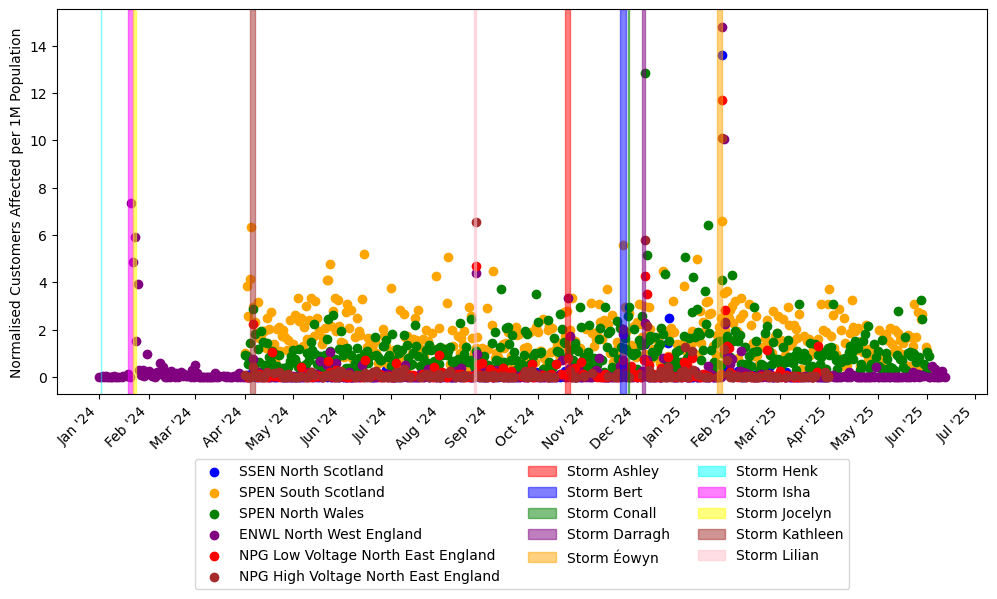

In [26]:
import matplotlib.dates as mdates

# Set up a dictionary for the storms
storms = {
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
    "Storm Henk": ["2024-01-02", "2024-01-02"],
    "Storm Isha": ["2024-01-19", "2024-01-22"],
    "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
}

# Set up different colours for the storms
storm_colours = {
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
    "Storm Henk": "cyan",
    "Storm Isha": "magenta",
    "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
}

# Set up figure
fig, ax = plt.subplots(figsize=(12, 5))

# Format the dates correctly without specifying a format
ssen_scotland_faults_2024_daily["Incident Day"] = pd.to_datetime(
    ssen_scotland_faults_2024_daily["Incident Day"], 
    errors='coerce', 
    utc=True
)

spen_south_scotland_faults_2024_daily["Incident Day"] = pd.to_datetime(
    spen_south_scotland_faults_2024_daily["Incident Day"],
    errors='coerce',
    utc=True
)

# format the other spen data correctly
spen_north_wales_faults_2024_daily["Incident Day"] = pd.to_datetime(
    spen_north_wales_faults_2024_daily["Incident Day"],
    errors='coerce',
    utc=True
)

# format the enwl data correctly
enwl_faults_2024_daily["Incident Day"] = pd.to_datetime(
    enwl_faults_2024_daily["Incident Day"],
    errors='coerce',
    utc=True
)

# format the npg low voltage data correctly
npg_lv_faults_2024_daily["Incident Day"] = pd.to_datetime(
    npg_lv_faults_2024_daily["Incident Day"],
    errors='coerce',
    utc=True
)

# format the npg high voltage data correctly
npg_hv_faults_2024_daily["Incident Day"] = pd.to_datetime(
    npg_hv_faults_2024_daily["Incident Day"],
    errors='coerce',
    utc=True
)

# Convert the dates to be concise
plt.rcParams['date.converter'] = 'concise'

# Plot the SSEN North Scotland data
ax.scatter(
    ssen_scotland_faults_2024_daily["Incident Day"], 
    ssen_scotland_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="SSEN North Scotland", 
    marker='o', 
    linestyle='-', 
    color='blue'
)

# # Do the same for SPEN South Scotland
ax.scatter(
    spen_south_scotland_faults_2024_daily["Incident Day"], 
    spen_south_scotland_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="SPEN South Scotland", 
    marker='o', 
    linestyle='-', 
    color='orange'
)

# Do the same for SPEN North Wales
ax.scatter(
    spen_north_wales_faults_2024_daily["Incident Day"], 
    spen_north_wales_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="SPEN North Wales", 
    marker='o', 
    linestyle='-', 
    color='green'
)

# plot the ENWL data
ax.scatter(
    enwl_faults_2024_daily["Incident Day"], 
    enwl_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="ENWL North West England", 
    marker='o', 
    linestyle='-', 
    color='purple'
)

# plot the npg data correctly
ax.scatter(
    npg_lv_faults_2024_daily["Incident Day"], 
    npg_lv_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="NPG Low Voltage North East England", 
    marker='o', 
    linestyle='-', 
    color='red'
)

ax.scatter(
    npg_hv_faults_2024_daily["Incident Day"], 
    npg_hv_faults_2024_daily["Normalised HV Customers Affected per 1M Population"], 
    label="NPG High Voltage North East England", 
    marker='o', 
    linestyle='-', 
    color='brown'
)


# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

    plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)

# Set x-axis ticks to the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))  # Format as "Jan '24" for month and year

# Rotate the x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add labels and legend
# ax.set_xlabel("Incident Month")
ax.set_ylabel("Normalised Customers Affected per 1M Population")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Show the plot
plt.show()

As the SPEN data does not included specification of fault cause, we want to smooth over some of the low frequency variability to try and identify the peaks.

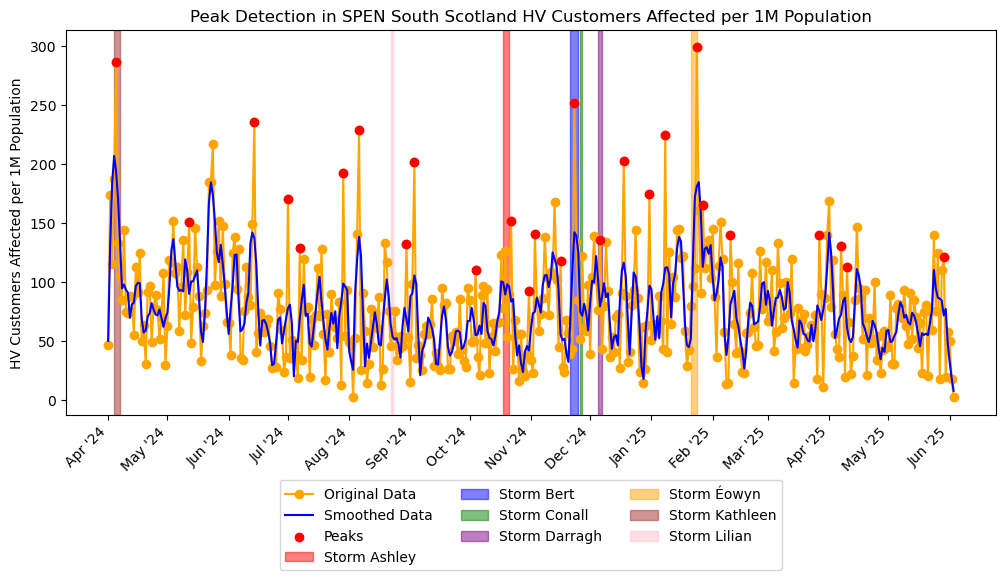

In [27]:
from scipy.signal import savgol_filter, find_peaks

# Set up a dictionary for the storms
storms = {
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
    "Storm Henk": ["2024-01-02", "2024-01-02"],
    "Storm Isha": ["2024-01-19", "2024-01-22"],
    "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
}

# Set up different colours for the storms
storm_colours = {
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
    "Storm Henk": "cyan",
    "Storm Isha": "magenta",
    "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
}

# Extract the south scotland values
south_scotland_values = spen_south_scotland_faults_2024_daily["HV Customers Affected per 1M Population"].values

# --- Smoothing the data ---
# Apply Savitzky-Golay filter to smooth the data
smoothed_south_scotland_values = savgol_filter(south_scotland_values, window_length=7, polyorder=2)


# --- Finding Peaks ---
residual_south_scotland_values = south_scotland_values - smoothed_south_scotland_values
peaks_south_scotland, _ = find_peaks(residual_south_scotland_values, prominence=100)

# --- Plotting the results ---
plt.figure(figsize=(12, 5))
plt.plot(spen_south_scotland_faults_2024_daily["Incident Day"], south_scotland_values, label="Original Data", marker='o', linestyle='-', color='orange')
plt.plot(spen_south_scotland_faults_2024_daily["Incident Day"], smoothed_south_scotland_values, label="Smoothed Data", color='blue')
plt.scatter(spen_south_scotland_faults_2024_daily["Incident Day"].iloc[peaks_south_scotland], south_scotland_values[peaks_south_scotland], color='red', label='Peaks', zorder=5)
plt.title("Peak Detection in SPEN South Scotland HV Customers Affected per 1M Population")
plt.ylabel("HV Customers Affected per 1M Population")

# Ensure the Incident Day column is timezone-naive
incident_days = spen_south_scotland_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

    # If the end date is not in the incident day range, skip it
    if end_date < incident_days.min() or start_date > incident_days.max():
        continue

    plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)

# Get the current axes object
ax = plt.gca()

# Set x-axis ticks to the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))  # Format as "Jan '24" for month and year

# Rotate the x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Show the plot
plt.show()

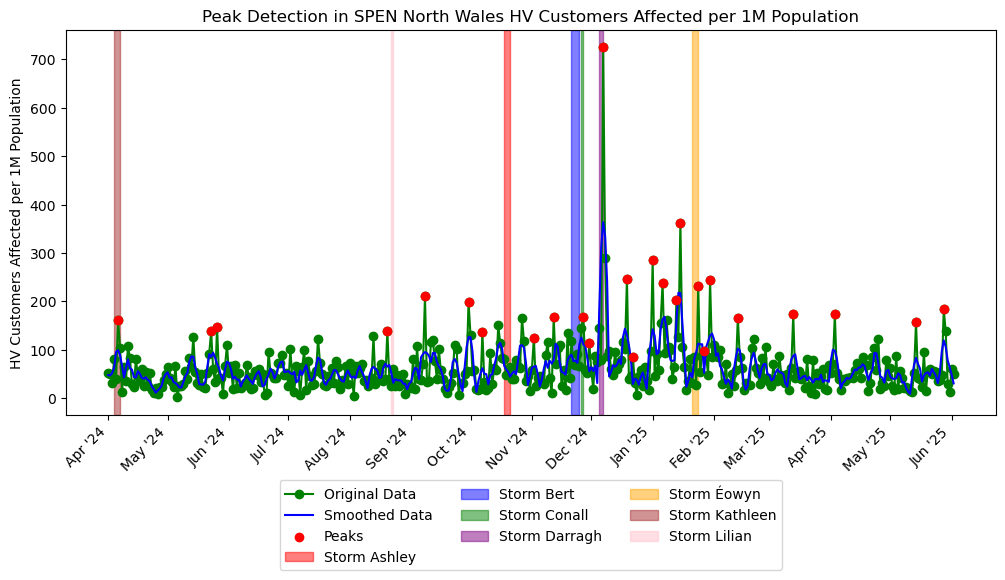

In [28]:
# Do the same with the north wales data
# Extract the north wales values
north_wales_values = spen_north_wales_faults_2024_daily["HV Customers Affected per 1M Population"].values

# --- Smoothing the data ---
# Apply Savitzky-Golay filter to smooth the data
smoothed_north_wales_values = savgol_filter(north_wales_values, window_length=7, polyorder=2)

# --- Finding Peaks ---
residual_north_wales_values = north_wales_values - smoothed_north_wales_values
peaks_north_wales, _ = find_peaks(residual_north_wales_values, prominence=100)

# --- Plotting the results ---
plt.figure(figsize=(12, 5))
plt.plot(spen_north_wales_faults_2024_daily["Incident Day"], north_wales_values, label="Original Data", marker='o', linestyle='-', color='green')
plt.plot(spen_north_wales_faults_2024_daily["Incident Day"], smoothed_north_wales_values, label="Smoothed Data", color='blue')
plt.scatter(spen_north_wales_faults_2024_daily["Incident Day"].iloc[peaks_north_wales], north_wales_values[peaks_north_wales], color='red', label='Peaks', zorder=5)
plt.title("Peak Detection in SPEN North Wales HV Customers Affected per 1M Population")
plt.ylabel("HV Customers Affected per 1M Population")
# Ensure the Incident Day column is timezone-naive
incident_days_north_wales = spen_north_wales_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

    # If the end date is not in the incident day range, skip it
    if end_date < incident_days_north_wales.min() or start_date > incident_days_north_wales.max():
        continue

    plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)

# Get the current axes object
ax = plt.gca()
# Set x-axis ticks to the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))  # Format as "Jan '24" for month and year
# Rotate the x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# Show the plot
plt.show()

In [29]:
# Set up the path to the file
file_path = "/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/max_10m_wind_gust_timeseries_dno_areas.csv"

# Set up the filepath for precip
precip_file_path = "/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/accumulated_precipitation_timeseries_dno_areas_mm_Jan_2025.csv"

# load in the file
wind_gust_jan = pd.read_csv(file_path, low_memory=False)

# load in the precipitation file
accumulated_precip_jan = pd.read_csv(precip_file_path, low_memory=False)

In [30]:
wind_gust_jan.head()

,Unnamed: 0,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
0,2025-01-01 00:00:00,21.790569,22.408733,20.229046,28.179241,21.928265,18.558147,18.694866,23.394085,22.347210,23.442913,20.486858,21.567913,20.033733,20.811077
1,2025-01-01 01:00:00,21.978304,22.712679,20.181429,28.451937,21.692171,18.090609,23.522249,23.335726,22.374788,23.245882,20.948030,22.240023,19.907015,21.140413
2,2025-01-01 02:00:00,22.127405,26.467249,19.950647,26.727991,21.581507,17.827600,25.434046,22.613733,22.144007,23.651819,21.429163,22.724085,19.141077,21.442835
3,2025-01-01 03:00:00,22.102224,22.977224,19.935232,26.342459,22.049490,17.006521,19.739920,22.535818,21.965506,24.385427,21.887381,22.745779,19.057302,21.730154
4,2025-01-01 04:00:00,21.453869,22.574963,20.183361,25.779064,22.900158,16.528088,21.873791,22.356213,22.116955,26.324963,22.396252,22.924572,19.617931,22.530041


In [31]:
accumulated_precip_jan.head()

,Unnamed: 0,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
0,2025-01-01 00:00:00,0.091553,13.537407,0.000000,54.483414,9.692192,41.419983,54.761887,68.855286,0.747681,8.079529,0.940323,39.603233,9.917259,0.573158
1,2025-01-01 01:00:00,0.109673,11.340618,0.000954,45.363426,5.465031,41.097641,54.702759,72.571278,0.631809,6.023884,0.982761,42.311192,7.815361,0.704765
2,2025-01-01 02:00:00,0.043869,5.958080,0.001907,47.002792,2.591133,42.454243,53.469181,81.766129,0.810146,5.983829,0.801563,42.064667,5.084038,0.560284
3,2025-01-01 03:00:00,0.010967,4.196644,0.000000,61.595440,3.033638,42.390823,56.142330,91.648102,0.638962,8.896351,0.589371,40.187836,5.306721,0.393391
4,2025-01-01 04:00:00,0.017643,7.376671,0.001431,83.508015,9.657860,44.279575,60.893059,82.112789,0.567436,22.346973,0.647545,49.242496,9.372711,0.440598


In [32]:
# Set "Unnamed: 0" as the index
wind_gust_jan.set_index("Unnamed: 0", inplace=True)
accumulated_precip_jan.set_index("Unnamed: 0", inplace=True)

In [33]:
# rename the index as time
wind_gust_jan.index.name = "Time"
accumulated_precip_jan.index.name = "Time"

In [34]:
# make sure the index is in datetime format
wind_gust_jan.index = pd.to_datetime(wind_gust_jan.index)
accumulated_precip_jan.index = pd.to_datetime(accumulated_precip_jan.index)

In [35]:
# Aggregate the data to daily frequency, taking the maximum value for each day
wind_gust_jan_daily = wind_gust_jan.resample('D').max()
# Aggregate the precipitation data to daily frequency, by summing the values for each day
accumulated_precip_jan_daily = accumulated_precip_jan.resample('D').sum()

In [36]:
wind_gust_jan_daily.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
Time,,,,,,,,,,,,,,
2025-01-01,23.895617,26.467249,22.551704,28.451937,24.416552,18.558147,25.434046,23.394085,26.241390,26.863960,24.997017,23.240370,20.033733,27.089273
2025-01-02,13.546037,11.212052,8.068870,10.588401,7.456565,13.599231,9.073629,27.466465,11.671971,9.727064,8.834081,12.469260,15.558981,8.658713
2025-01-03,13.932980,12.596148,8.582997,12.161495,10.148230,15.588996,13.669121,22.868099,10.518441,8.422660,6.501942,13.474018,17.842667,8.212880
2025-01-04,13.235153,11.241013,11.480270,14.552536,12.383591,9.495226,11.288864,14.899035,16.794724,17.329084,22.662996,9.380661,13.150192,16.102341
2025-01-05,19.472536,20.979372,19.257692,16.188749,18.283083,14.798022,18.472536,17.869253,22.526970,20.699850,20.573355,17.166872,15.984352,22.052614


In [37]:
accumulated_precip_jan_daily.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
Time,,,,,,,,,,,,,,
2025-01-01,320.651054,361.131191,18.241882,535.473347,293.684006,397.459507,474.035740,932.454586,161.591530,382.221699,351.297379,440.929413,307.592392,353.776455
2025-01-02,7.123470,0.103951,0.011921,3.987789,0.053883,6.206512,0.000000,263.345718,2.051830,3.275871,3.046989,1.048088,3.187180,0.090599
2025-01-03,1.342773,0.880241,0.000000,16.520500,0.356197,0.985622,21.922588,231.274605,0.000000,2.827168,0.316143,2.624035,33.446312,0.000000
2025-01-04,40.300369,38.601398,6.670952,63.729286,89.791298,4.783630,46.617031,230.863571,58.758736,234.623432,423.971653,8.412838,44.175625,271.897316
2025-01-05,574.303150,720.840931,44.236660,768.912792,429.750919,641.242027,630.217075,132.017136,310.309887,626.137257,346.655369,599.165916,277.759552,667.534351


In [38]:
# Add a new column to wind_gust_jan_daily for the ENWL normalised wind gusts anoms
start_date_jan = wind_gust_jan_daily.index[0]
end_date_jan = wind_gust_jan_daily.index[-1]

# make sure incident day is tz-localized to UTC
enwl_faults_2024_daily["Incident Day"] = enwl_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# format the ssen incident day to localized UTC
ssen_scotland_faults_2024_daily["Incident Day"] = ssen_scotland_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# format the spen south scotland incident day to localized UTC
spen_south_scotland_faults_2024_daily["Incident Day"] = spen_south_scotland_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# format the spen north wales incident day to localized UTC
spen_north_wales_faults_2024_daily["Incident Day"] = spen_north_wales_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# npg low voltage faults incident day to localized UTC
npg_lv_faults_2024_daily["Incident Day"] = npg_lv_faults_2024_daily["Incident Day"].dt.tz_localize(None)
# npg high voltage faults incident day to localized UTC
npg_hv_faults_2024_daily["Incident Day"] = npg_hv_faults_2024_daily["Incident Day"].dt.tz_localize(None)

# Limit the ENWL faults to the date range of the wind gust data
enwl_faults_2024_daily_subset_jan = enwl_faults_2024_daily[
    (enwl_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (enwl_faults_2024_daily["Incident Day"] <= end_date_jan)
]

# Limit the SSEN Scotland faults to the date range of the wind gust data
ssen_scotland_faults_2024_daily_subset_jan = ssen_scotland_faults_2024_daily[
    (ssen_scotland_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (ssen_scotland_faults_2024_daily["Incident Day"] <= end_date_jan)
]

# Limit the SPEN South Scotland faults to the date range of the wind gust data
spen_south_scotland_faults_2024_daily_subset_jan = spen_south_scotland_faults_2024_daily[
    (spen_south_scotland_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (spen_south_scotland_faults_2024_daily["Incident Day"] <= end_date_jan)
]

# Limit the SPEN North Wales faults to the date range of the wind gust data
spen_north_wales_faults_2024_daily_subset_jan = spen_north_wales_faults_2024_daily[
    (spen_north_wales_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (spen_north_wales_faults_2024_daily["Incident Day"] <= end_date_jan)
]

# Limit the NPG Low Voltage faults to the date range of the wind gust data
npg_lv_faults_2024_daily_subset_jan = npg_lv_faults_2024_daily[
    (npg_lv_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (npg_lv_faults_2024_daily["Incident Day"] <= end_date_jan)
]

# Limit the NPG High Voltage faults to the date range of the wind gust data
npg_hv_faults_2024_daily_subset_jan = npg_hv_faults_2024_daily[
    (npg_hv_faults_2024_daily["Incident Day"] >= start_date_jan) & 
    (npg_hv_faults_2024_daily["Incident Day"] <= end_date_jan)
]

In [39]:
# Set up the dfs
fault_dfs_jan = [
    ssen_scotland_faults_2024_daily_subset_jan,
    spen_south_scotland_faults_2024_daily_subset_jan,
    enwl_faults_2024_daily_subset_jan,
    npg_hv_faults_2024_daily_subset_jan,
    npg_lv_faults_2024_daily_subset_jan,
    spen_north_wales_faults_2024_daily_subset_jan
]

regions = [
    "North Scotland",
    "South and Central Scotland",
    "North West England",
    "North East England",
    "North East England",
    "North Wales, Merseyside and Cheshire",
]

# Set up the DNOs
dno_names = [
    "SSEN",
    "SPEN",
    "ENWL",
    "NPG High Voltage",
    "NPG Low Voltage",
    "SPEN",
]

In [40]:
wind_gust_jan_daily.columns

Index(['East England', 'East Midlands', 'London',
       'North Wales, Merseyside and Cheshire', 'West Midlands',
       'North East England', 'North West England', 'North Scotland',
       'South East England', 'South Wales', 'South West England', 'Yorkshire',
       'South and Central Scotland', 'Southern England'],
      dtype='object')

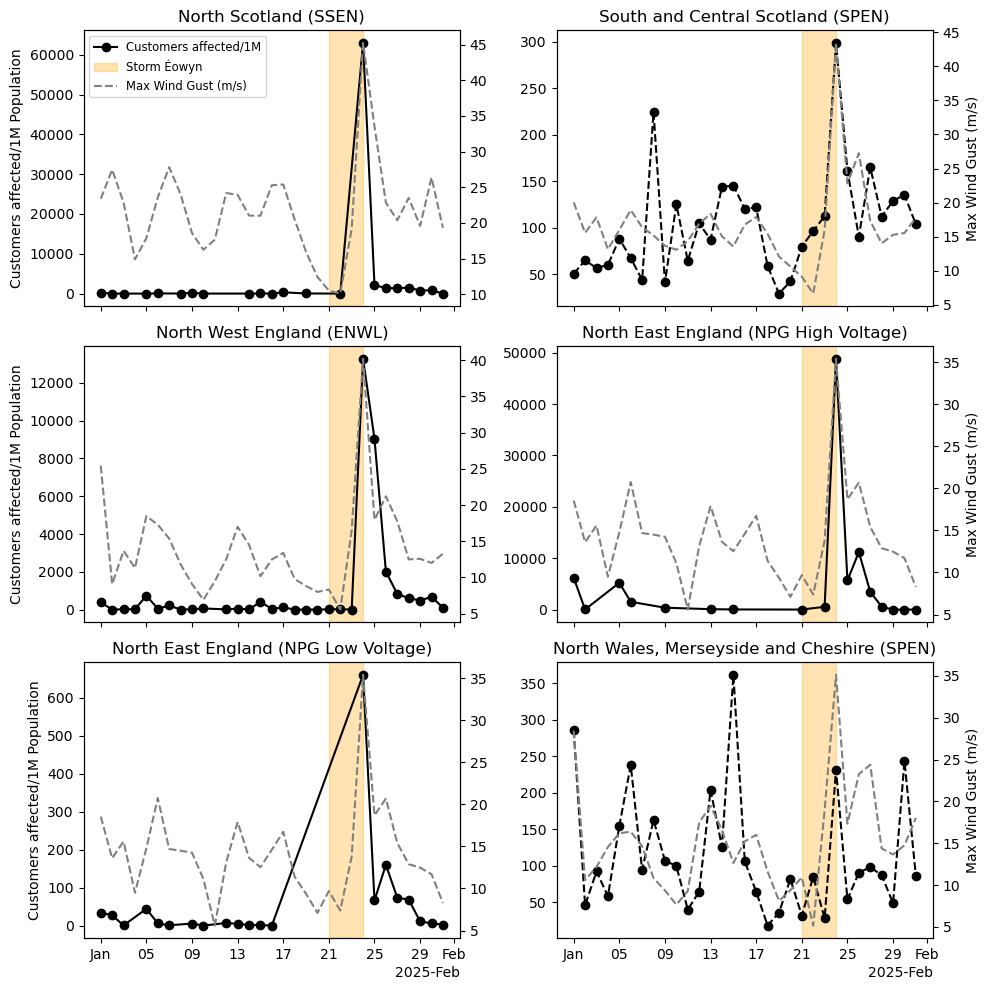

In [41]:
# Set up the figure wit 2 columns and 3 rows
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the dataframes and plot each one
for i, (df, region) in enumerate(zip(fault_dfs_jan, regions)):

    # if the region is "South and Central Scotland" or "North Wales, Merseyside and Cheshire", skip it
    # then plot as dashed line
    if region in ["South and Central Scotland", "North Wales, Merseyside and Cheshire"]:
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="--",
            label=f"Customers affected/1M",
        )
    else:
        # Plot the HV Customers Affected per 1M Population
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="-",
            label=f"Customers affected/1M",
        )

    # # Plot the HV Customers Affected per 1M Population
    # axs[i].plot(df["Incident Day"], df["HV Customers Affected per 1M Population"], marker='o', linestyle='-', label=f"{region} HV Customers Affected per 1M Population")

    # set up the duplicate y-axis on the right side
    ax2_this = axs[i].twinx()

    # Duplicat the y-axis on the right side
    ax2_this.plot(
        wind_gust_jan_daily.index,
        wind_gust_jan_daily[region],
        color="grey",
        linestyle="--",
        label="Max Wind Gust (m/s)",
    )

    # Set the title and labels
    axs[i].set_title(f"{region} ({dno_names[i]})")

    # only if i is 0, 2, 4, set the x label
    if i in [0, 2, 4]:
        axs[i].set_ylabel("Customers affected/1M Population")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 5]:
        ax2_this.set_ylabel("Max Wind Gust (m/s)")
    else:
        ax2_this.set_ylabel("")

    # highlight the storm Eowyn period
    storm_eowyn_start = pd.to_datetime("2025-01-21").tz_localize(None)
    storm_eowyn_end = pd.to_datetime("2025-01-24").tz_localize(None)
    axs[i].axvspan(
        storm_eowyn_start,
        storm_eowyn_end,
        color="orange",
        alpha=0.3,
        label="Storm Éowyn",
    )

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2


    # axs[i].set_ylabel("Customers affected/1M Population")

    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper left", fontsize="small")

    # # Add a legend
    # axs[i].legend()

# Set a tight layout
plt.tight_layout()

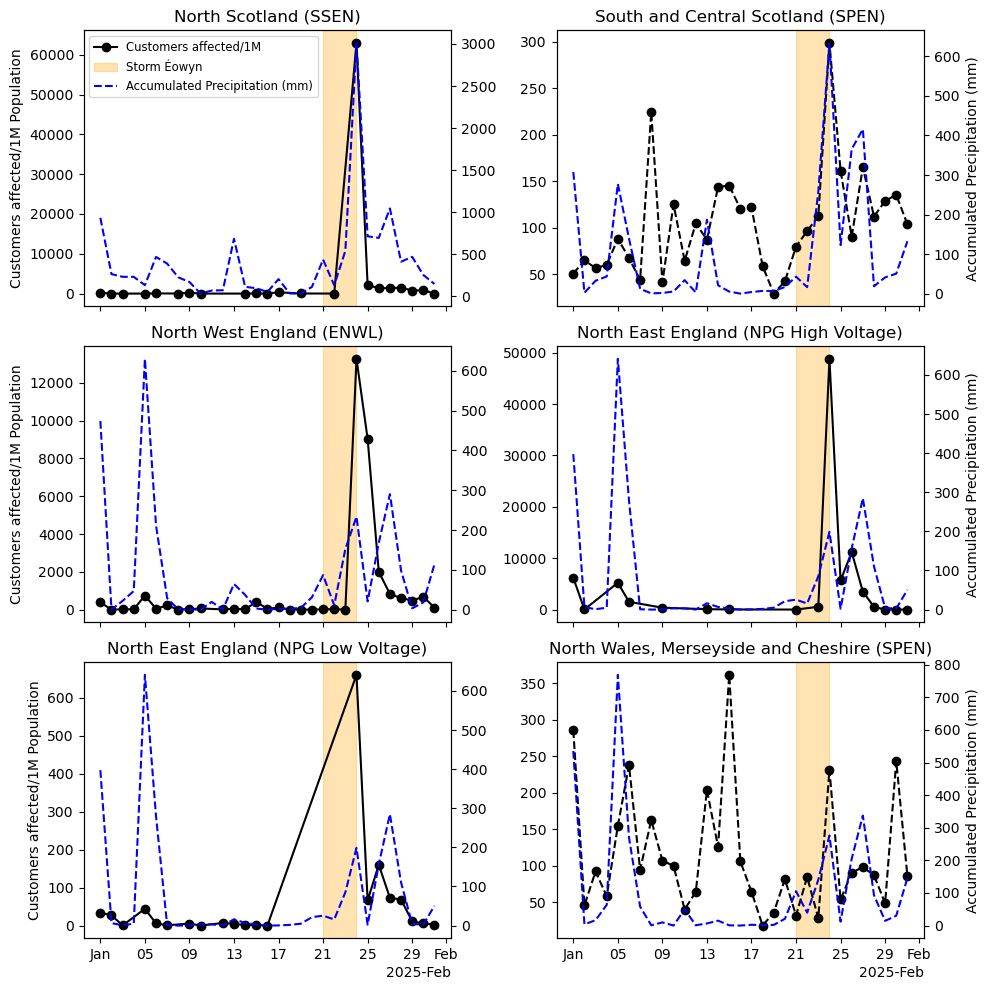

In [42]:
# Do the same, but for precip data instead
# Set up the figure wit 2 columns and 3 rows
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the dataframes and plot each one
for i, (df, region) in enumerate(zip(fault_dfs_jan, regions)):

    # if the region is "South and Central Scotland" or "North Wales, Merseyside and Cheshire", skip it
    # then plot as dashed line
    if region in ["South and Central Scotland", "North Wales, Merseyside and Cheshire"]:
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="--",
            label=f"Customers affected/1M",
        )
    else:
        # Plot the HV Customers Affected per 1M Population
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="-",
            label=f"Customers affected/1M",
        )

    # # Plot the HV Customers Affected per 1M Population
    # axs[i].plot(df["Incident Day"], df["HV Customers Affected per 1M Population"], marker='o', linestyle='-', label=f"{region} HV Customers Affected per 1M Population")

    # set up the duplicate y-axis on the right side
    ax2_this = axs[i].twinx()

    # Duplicat the y-axis on the right side
    ax2_this.plot(
        accumulated_precip_jan_daily.index,
        accumulated_precip_jan_daily[region],
        color="blue",
        linestyle="--",
        label="Accumulated Precipitation (mm)",
    )

    # Set the title and labels
    axs[i].set_title(f"{region} ({dno_names[i]})")

    # only if i is 0, 2, 4, set the x label
    if i in [0, 2, 4]:
        axs[i].set_ylabel("Customers affected/1M Population")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 5]:
        ax2_this.set_ylabel("Accumulated Precipitation (mm)")
    else:
        ax2_this.set_ylabel("")

    # highlight the storm Eowyn period
    storm_eowyn_start = pd.to_datetime("2025-01-21").tz_localize(None)
    storm_eowyn_end = pd.to_datetime("2025-01-24").tz_localize(None)
    axs[i].axvspan(
        storm_eowyn_start,
        storm_eowyn_end,
        color="orange",
        alpha=0.3,
        label="Storm Éowyn",
    )

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2


    # axs[i].set_ylabel("Customers affected/1M Population")

    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper left", fontsize="small")

    # # Add a legend
    # axs[i].legend()

# Set a tight layout
plt.tight_layout()

In [43]:
# Load in the full percip data to look over the full winter
full_precip_file_path = "/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/total_precip_timeseries_dno_areas_Nov_2024-Mar_2025.csv"

full_precip_data = pd.read_csv(full_precip_file_path, low_memory=False)

In [44]:
full_precip_data.tail()

,Unnamed: 0,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
3619,2025-03-31 19:00:00,0.0,0.0,0.0,0.001907,0.0,0.0,0.0,0.139713,0.0,0.0,0.0,0.0,0.003338,0.0
3620,2025-03-31 20:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034809,0.0,0.0,0.0,0.0,0.000000,0.0
3621,2025-03-31 21:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024319,0.0,0.0,0.0,0.0,0.000000,0.0
3622,2025-03-31 22:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.007629,0.0,0.0,0.0,0.0,0.000000,0.0
3623,2025-03-31 23:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000477,0.0,0.0,0.0,0.0,0.000000,0.0


In [45]:
# Set "Unnamed: 0" as the index
full_precip_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_precip_data.index.name = "Time"

# Ensure this index is in datetime format
full_precip_data.index = pd.to_datetime(full_precip_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_precip_data_daily = full_precip_data.resample('D').sum()

In [46]:
# Set up the start date for this
start_date_full_precip = full_precip_data_daily.index[0]
end_date_full_precip = full_precip_data_daily.index[-1]

# Limit the ENWL faults to the date range of the full precipitation data
enwl_faults_2024_daily_subset_full_precip = enwl_faults_2024_daily[
    (enwl_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (enwl_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

# Limit the SSEN Scotland faults to the date range of the full precipitation data
ssen_scotland_faults_2024_daily_subset_full_precip = ssen_scotland_faults_2024_daily[
    (ssen_scotland_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (ssen_scotland_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

# Limit the SPEN South Scotland faults to the date range of the full precipitation data
spen_south_scotland_faults_2024_daily_subset_full_precip = spen_south_scotland_faults_2024_daily[
    (spen_south_scotland_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (spen_south_scotland_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

# Limit the SPEN North Wales faults to the date range of the full precipitation data
spen_north_wales_faults_2024_daily_subset_full_precip = spen_north_wales_faults_2024_daily[
    (spen_north_wales_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (spen_north_wales_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

# Limit the NPG Low Voltage faults to the date range of the full precipitation data
npg_lv_faults_2024_daily_subset_full_precip = npg_lv_faults_2024_daily[
    (npg_lv_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (npg_lv_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

# Limit the NPG High Voltage faults to the date range of the full precipitation data
npg_hv_faults_2024_daily_subset_full_precip = npg_hv_faults_2024_daily[
    (npg_hv_faults_2024_daily["Incident Day"] >= start_date_full_precip) & 
    (npg_hv_faults_2024_daily["Incident Day"] <= end_date_full_precip)
]

In [47]:
# Set up the dfs
fault_dfs_full_precip = [
    ssen_scotland_faults_2024_daily_subset_full_precip,
    spen_south_scotland_faults_2024_daily_subset_full_precip,
    enwl_faults_2024_daily_subset_full_precip,
    npg_hv_faults_2024_daily_subset_full_precip,
    npg_lv_faults_2024_daily_subset_full_precip,
    spen_north_wales_faults_2024_daily_subset_full_precip
]

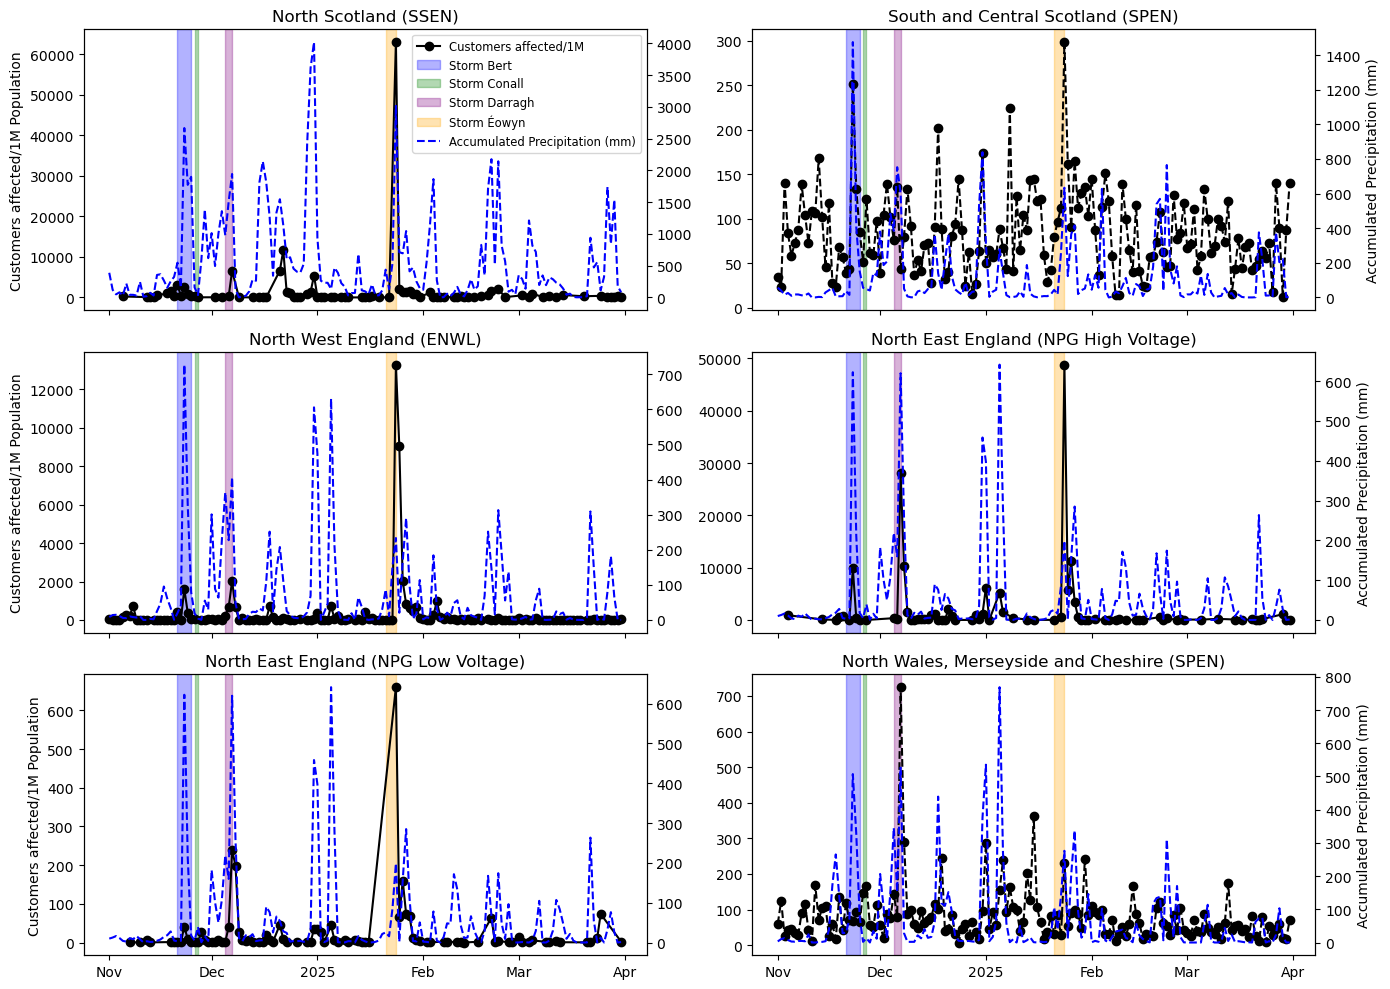

In [48]:
# Set up a figure with 3 row and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the dataframes and plot each one
for i, (df, region) in enumerate(zip(fault_dfs_full_precip, regions)):

    # if the region is "South and Central Scotland" or "North Wales, Merseyside and Cheshire", skip it
    # then plot as dashed line
    if region in ["South and Central Scotland", "North Wales, Merseyside and Cheshire"]:
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="--",
            label=f"Customers affected/1M",
        )
    else:
        # Plot the HV Customers Affected per 1M Population
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="-",
            label=f"Customers affected/1M",
        )

    # # Plot the HV Customers Affected per 1M Population
    # axs[i].plot(df["Incident Day"], df["HV Customers Affected per 1M Population"], marker='o', linestyle='-', label=f"{region} HV Customers Affected per 1M Population")

    # set up the duplicate y-axis on the right side
    ax2_this = axs[i].twinx()

    # Duplicat the y-axis on the right side
    ax2_this.plot(
        full_precip_data_daily.index,
        full_precip_data_daily[region],
        color="blue",
        linestyle="--",
        label="Accumulated Precipitation (mm)",
    )

    # Set the title and labels
    axs[i].set_title(f"{region} ({dno_names[i]})")

    # only if i is 0, 2, 4, set the x label
    if i in [0, 2, 4]:
        axs[i].set_ylabel("Customers affected/1M Population")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 5]:
        ax2_this.set_ylabel("Accumulated Precipitation (mm)")
    else:
        ax2_this.set_ylabel("")

    # Loop over and plot the storms (within the start and end dates of the full precipitation data)
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

        # If the end date is not in the incident day range, skip it
        if end_date < df["Incident Day"].min() or start_date > df["Incident Day"].max():
            continue

        axs[i].axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.3, label=storm)

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2
    # axs[i].set_ylabel("Customers affected/1M Population")
    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper right", fontsize="small")

    # # Add a legend
    # axs[i].legend()
        
# Set a tight layout
plt.tight_layout()

In [54]:
# Set uip the path to the full wind gust data
full_wind_gust_file_path = "/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/max_10m_wind_gusts_timeseries_DNO_areas_Nov_2024-Mar_2025.csv"

# Load in the full wind gust data
full_wind_gust_data = pd.read_csv(full_wind_gust_file_path, low_memory=False)

In [55]:
# Set "Unnamed: 0" as the index
full_wind_gust_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_wind_gust_data.index.name = "Time"

# Ensure this index is in datetime format
full_wind_gust_data.index = pd.to_datetime(full_wind_gust_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_wind_gust_data_daily = full_wind_gust_data.resample('D').max()

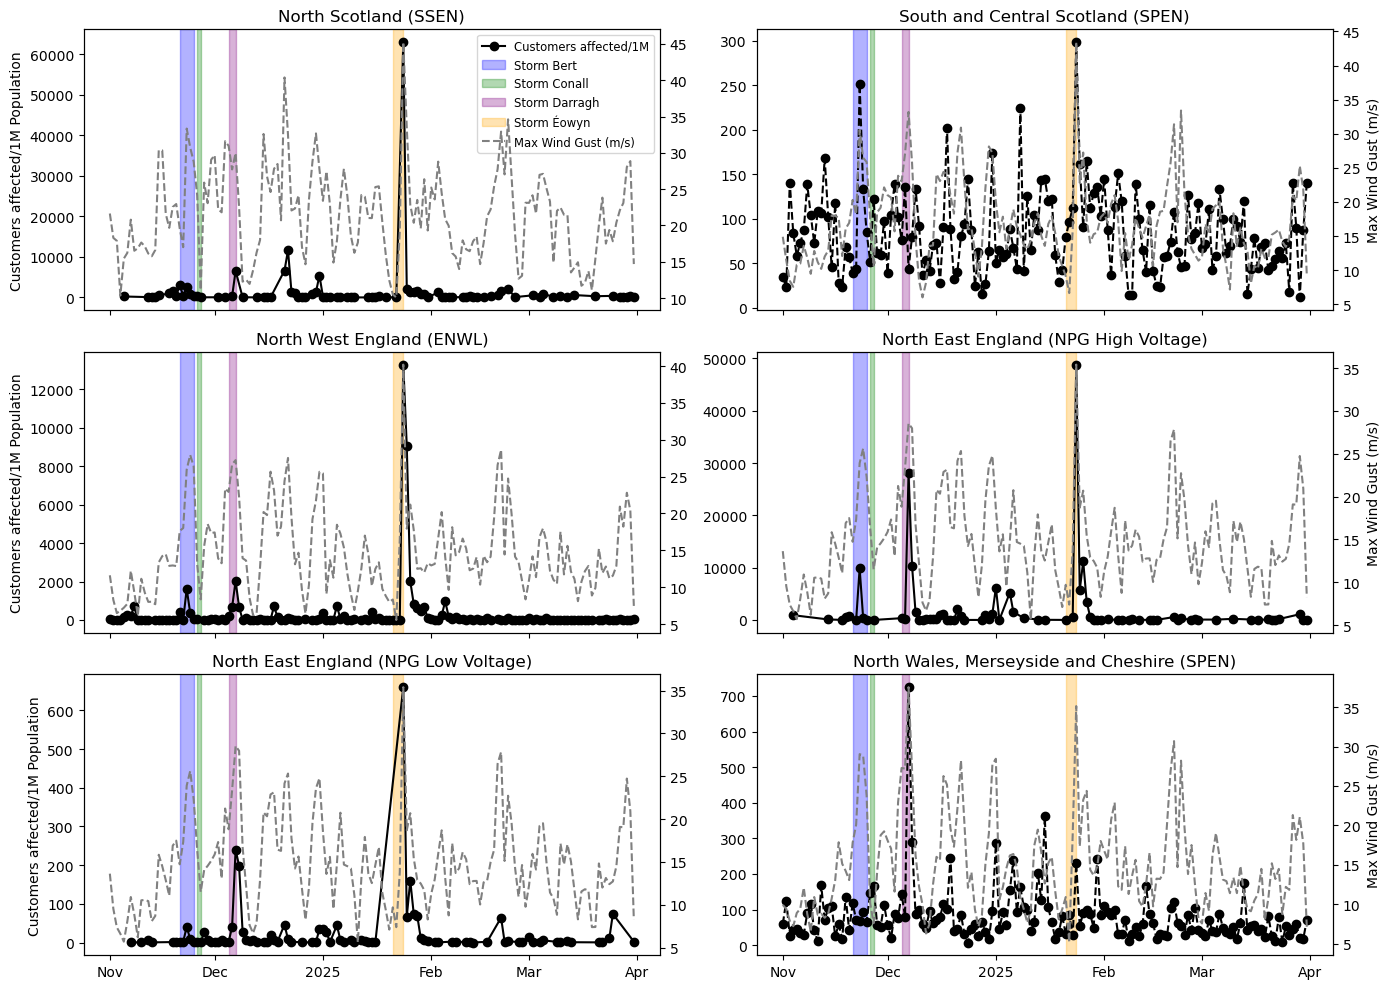

In [58]:
# Set up a figure with 3 row and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the dataframes and plot each one
for i, (df, region) in enumerate(zip(fault_dfs_full_precip, regions)):

    # if the region is "South and Central Scotland" or "North Wales, Merseyside and Cheshire", skip it
    # then plot as dashed line
    if region in ["South and Central Scotland", "North Wales, Merseyside and Cheshire"]:
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="--",
            label=f"Customers affected/1M",
        )
    else:
        # Plot the HV Customers Affected per 1M Population
        axs[i].plot(
            df["Incident Day"],
            df["HV Customers Affected per 1M Population"],
            color="k",
            marker="o",
            linestyle="-",
            label=f"Customers affected/1M",
        )

    # # Plot the HV Customers Affected per 1M Population
    # axs[i].plot(df["Incident Day"], df["HV Customers Affected per 1M Population"], marker='o', linestyle='-', label=f"{region} HV Customers Affected per 1M Population")

    # set up the duplicate y-axis on the right side
    ax2_this = axs[i].twinx()

    # # Duplicat the y-axis on the right side
    # ax2_this.plot(
    #     full_precip_data_daily.index,
    #     full_precip_data_daily[region],
    #     color="blue",
    #     linestyle="--",
    #     label="Accumulated Precipitation (mm)",
    # )

    # Duplicat the y-axis on the right side
    ax2_this.plot(
        full_wind_gust_data_daily.index,
        full_wind_gust_data_daily[region],
        color="grey",
        linestyle="--",
        label="Max Wind Gust (m/s)",
    )

    # Set the title and labels
    axs[i].set_title(f"{region} ({dno_names[i]})")

    # only if i is 0, 2, 4, set the x label
    if i in [0, 2, 4]:
        axs[i].set_ylabel("Customers affected/1M Population")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 5]:
        ax2_this.set_ylabel("Max Wind Gust (m/s)")
    else:
        ax2_this.set_ylabel("")

    # Loop over and plot the storms (within the start and end dates of the full precipitation data)
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

        # If the end date is not in the incident day range, skip it
        if end_date < df["Incident Day"].min() or start_date > df["Incident Day"].max():
            continue

        axs[i].axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.3, label=storm)

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2
    # axs[i].set_ylabel("Customers affected/1M Population")
    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper right", fontsize="small")

    # # Add a legend
    # axs[i].legend()
        
# Set a tight layout
plt.tight_layout()

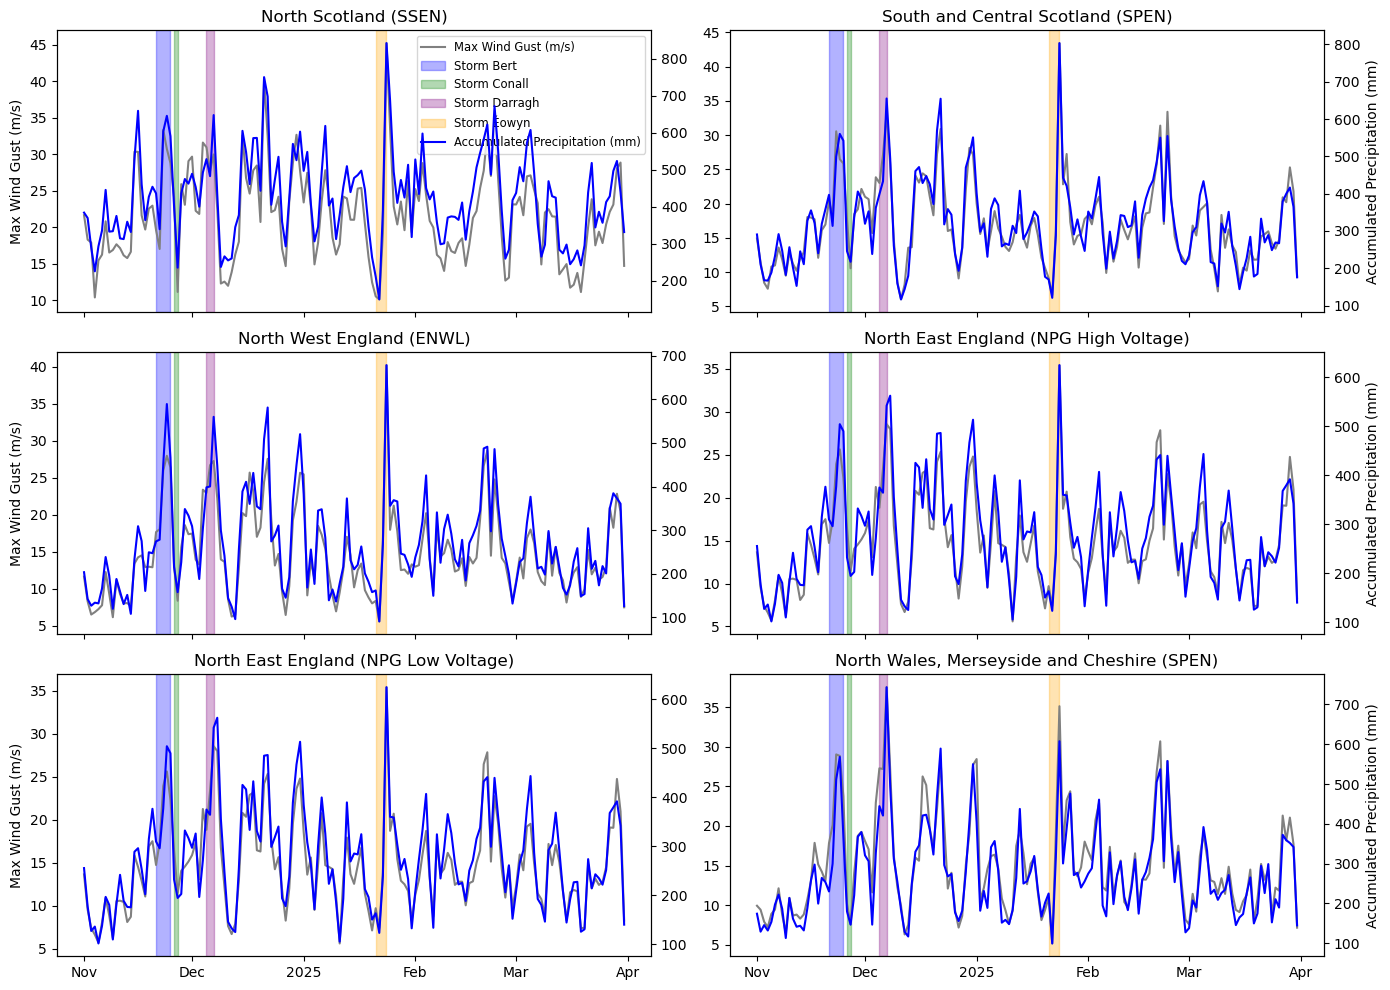

In [59]:
# Set up a figure with 3 row and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the dataframes and plot each one
for i, (df, region) in enumerate(zip(fault_dfs_full_precip, regions)):

    # Plot the wind gust data for this region
    axs[i].plot(
        full_wind_gust_data_daily.index,
        full_wind_gust_data_daily[region],
        color="grey",
        label="Max Wind Gust (m/s)",
    )

    # # Plot the HV Customers Affected per 1M Population
    # axs[i].plot(df["Incident Day"], df["HV Customers Affected per 1M Population"], marker='o', linestyle='-', label=f"{region} HV Customers Affected per 1M Population")

    # set up the duplicate y-axis on the right side
    ax2_this = axs[i].twinx()

    # Duplicat the y-axis on the right side
    ax2_this.plot(
        full_precip_data_daily.index,
        full_precip_data_daily[region],
        color="blue",
        label="Accumulated Precipitation (mm)",
    )

    # Set the title and labels
    axs[i].set_title(f"{region} ({dno_names[i]})")

    # only if i is 0, 2, 4, set the x label
    if i in [0, 2, 4]:
        axs[i].set_ylabel("Max Wind Gust (m/s)")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 5]:
        ax2_this.set_ylabel("Accumulated Precipitation (mm)")
    else:
        ax2_this.set_ylabel("")

    # Loop over and plot the storms (within the start and end dates of the full precipitation data)
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

        # If the end date is not in the incident day range, skip it
        if end_date < df["Incident Day"].min() or start_date > df["Incident Day"].max():
            continue
        axs[i].axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.3, label=storm)

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2
    # axs[i].set_ylabel("Customers affected/1M Population")
    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper right", fontsize="small")
        
# Set a tight layout
plt.tight_layout()